# Crawler by PPO

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment
The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
from datetime import datetime
def MSG(txt):
    print(datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), str(txt))
from ppo_agent import Agent
import matplotlib.pyplot as plt
import sys
import random
%matplotlib inline

env = UnityEnvironment(file_name='data/Crawler_Linux/Crawler.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents
n_agent = len(env_info.agents)
print("there are %d identical agents in the env"%n_agent)
# size of each action
action_size = brain.vector_action_space_size
# size of state space 
state_size = env_info.vector_observations.shape[1]

there are 12 identical agents in the env


### 3. Proximal Policy Optimization Algorithms

[PPO](https://arxiv.org/abs/1707.06347) is a new family of policy gradient methods for reinforcement learning, which alternate between sampling data through interaction with the environment, and optimizing a "surrogate" objective function using stochastic gradient ascent.
![PPO](src/img/ppo.png)

Details of our algorithm:

1. 3-hidden layer (relu+bn) + tanh outlayer Actor Netwok
2. 3-hidden layer (relu+bn) + tanh outlayer  Critic Netwok

Some hyper-parameters:

Hyper-Parameter | Value | Description
----------|-----------|--------------
BATCH_SIZE | 1024          |  minibatch size
MIN_BATCH_NUM  |  32         |  the minimum number of batch in each learning epoch
GAMMA  |  0.99               |  discount factor
TAU  |  0.99                 |  discount factor
LEARNING_RATE  |  1e-4       |  learning rate of the actor
EPSILON  |  1e-5             |  epsilon of Adam
WEIGHT_DECAY  |  1e-4        |  weight decay of Adam
PPO_CLIP  |  0.2             |  clip factor in ppo
CLIP_GRAD  |  1              |  clip factor of gradient
ENTROPY_COEFFICENT  |  0.01  |  coefficent of entropy
NOISE_REDUCE  |  0.999       |  reduce the threshold of std in action

2018-12-10 23:55:08: start!
Episode 100	Current Episode Average Score: 565.25	Average Score on 100 Episode: 260.23	Average Step: 1500
Episode 200	Current Episode Average Score: 801.42	Average Score on 100 Episode: 742.79	Average Step: 1500
Episode 300	Current Episode Average Score: 950.61	Average Score on 100 Episode: 893.02	Average Step: 1500
Episode 400	Current Episode Average Score: 902.99	Average Score on 100 Episode: 937.84	Average Step: 1500
Episode 500	Current Episode Average Score: 1054.52	Average Score on 100 Episode: 1036.98	Average Step: 1500
Episode 600	Current Episode Average Score: 851.55	Average Score on 100 Episode: 977.41	Average Step: 1500
Episode 700	Current Episode Average Score: 1204.22	Average Score on 100 Episode: 1206.49	Average Step: 1500
Episode 800	Current Episode Average Score: 1355.03	Average Score on 100 Episode: 1260.61	Average Step: 1500
Episode 900	Current Episode Average Score: 1336.62	Average Score on 100 Episode: 1344.46	Average Step: 1500
Episode 10

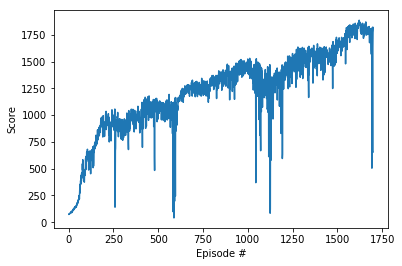

In [4]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2, n_agent=n_agent)

def ppo(env, agent, n_episodes=1700, max_t=1500, print_every=100, n_agent = 12):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int): number of episodes to print result
        n_agent (int): number of identical agents in environment
    """
    MSG('start!')
    brain_name = env.brain_names[0]
    scores_deque = deque(maxlen=print_every)
    t_mean = deque(maxlen=print_every//100)
    scores = []
    best_score = 0.
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent_scores = np.zeros(n_agent)
        for t in range(max_t):
            actions, log_probs, _, values = agent.act(states)
            # get needed information from environment
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = np.array([1 if t else 0 for t in env_info.local_done])
            agent.save_step([states, values.detach(), actions, log_probs.detach(), rewards, 1 - dones])
            states = next_states
            agent_scores += rewards
            if all(dones) or (t+1) == max_t:
                t_mean.append(t+1)
            if (t+1) == max_t:
                agent.step(next_states)
                break
        score = np.mean(agent_scores)
        scores_deque.append(score)
        scores.append(score)

        if score > best_score:
            torch.save(agent.actor_critic.state_dict(), 'checkpoint.pth')
            best_score = score

        if i_episode % (print_every) == 0:
            print('\rEpisode {}\tCurrent Episode Average Score: {:.2f}\tAverage Score on 100 Episode: {:.2f}\tAverage Step: {:.0f}'.format(i_episode, 
                        score, np.mean(scores_deque), np.mean(t_mean)))
    MSG('\nend!')
    return scores


scores = ppo(env, agent, n_agent=n_agent)

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()